In [181]:
from pearce.emulator.emu import OriginalRecipe, ExtraCrispy
from pearce.emulator.trainingData import parameter, PARAMS

In [182]:
from george.kernels import ExpSquaredKernel
import george

In [183]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from itertools import cycle
colors = cycle(sns.color_palette())

In [184]:
training_dir = '/u/ki/swmclau2/des/PearceLHC/'
#training_dir = '/u/ki/swmclau2/des/PearceData/'

In [185]:
y_param = 'logMmin'
emulation_point = [('f_c', 0.233), ('logM0', 12.0), ('sigma_logM', 0.533), 
                   ('alpha', 1.083),('logM1', 13.5), ('logMmin', 12.233)]
idx = 2
#em_params = dict(emulation_point[:idx])
#fixed_params = dict(emulation_point[idx:])

em_params = dict(emulation_point)
fixed_params={}
#del em_params[y_param]

In [186]:
or_params = PARAMS[:]
or_params.append(parameter('r', 0, 1)) #95% sure bounds aren't used for r
emu = OriginalRecipe(training_dir,or_params, fixed_params=fixed_params)
#emu = ExtraCrispy(training_dir)

In [187]:
print emu.metric.shape

(8,)


In [188]:
print fixed_params

{}


In [189]:
for p, val in zip(or_params, emu.metric[1:]):
    print p.name, val

logMmin 0.1349
sigma_logM 0.089
logM0 2.0
logM1 0.204
alpha 0.039
f_c 0.041
r 0.04


In [190]:
print emu.metric

[ 0.481   0.1349  0.089   2.      0.204   0.039   0.041   0.04  ]


In [191]:
print emu.metric

[ 0.481   0.1349  0.089   2.      0.204   0.039   0.041   0.04  ]


In [192]:
ig = emu.get_initial_guess('xi', {})
a = ig['amp']#*100
kernel = a * ExpSquaredKernel(emu.metric[1:], ndim=emu.emulator_ndim)
loo_gp = george.GP(kernel)
# gp = george.GP(kernel, solver=george.HODLRSolver, nleaf=x.shape[0]+1,tol=1e-18)

loo_gp.compute(emu.x[1:], emu.yerr[1:])  # NOTE I'm using a modified version of george!

In [193]:
for key, val in ig.iteritems():
    print key,'\t',val

logM1 	0.204
logMmin 	0.1349
r 	0.04
sigma_logM 	0.089
logM0 	2.0
amp 	0.481
alpha 	0.039
f_c 	0.041


In [194]:
K = emu.gp.kernel.value(emu.x)
print np.diag(K)[0]
print emu.yerr[0]**2

0.481
0.000107759704628


In [195]:
K_inv_full = emu.gp.solver.apply_inverse(np.eye(emu.x.shape[0]),in_place=True)

In [196]:
from os import path
save_dir = '/u/ki/swmclau2/des/EmulatorMCMC/'
rpoints = np.log10(np.loadtxt(path.join(save_dir, 'rpoints.npy')) )
true_vals = np.log10( np.loadtxt(path.join(save_dir, 'xi.npy')) )

In [197]:
rbins = np.array([  0.06309573,   0.12437607,   0.24517359,   0.34422476, 0.48329302, 0.67854546,\
           0.9526807 , 1.33756775,1.8779508 ,   2.6366509 ,   3.70186906,   5.19743987, 7.29722764, \
           10.24533859,  14.38449888,  20.1958975 , 28.35512583,  39.81071706] )
#rpoints= np.log10((rbins[1:]+rbins[:-1])/2)
em_params['r'] = rpoints#[:2]

In [198]:
print emu.fixed_ndim, emu.emulator_ndim, len(em_params), len(emu.fixed_params)
mu, G = emu.emulate(em_params)
print mu

0 7 7 0
[ 3.33430587  2.92689423  2.49717286  2.20846211  1.87173901  1.48554091
  1.09514167  0.75355011  0.48323972  0.25937854  0.02380753 -0.20503501
 -0.47126951 -0.73669219 -1.04039574 -1.40426527 -1.90917015]


In [199]:
print np.sqrt(np.diag(G))

[ 0.05211012  0.05114828  0.05107489  0.05103079  0.05102867  0.0510421
  0.05105465  0.05103387  0.05100028  0.05099512  0.05099858  0.05100285
  0.05101041  0.051046    0.05119052  0.05214022  0.06014086]


In [139]:
input_params = {}
input_params.update(em_params)
#input_params.update(fixed_params)

# i'd like to remove 'r'. possibly requiring a passed in param?
t_list = [input_params[p.name] for p in emu.ordered_params if p.name in em_params]
t_grid = np.meshgrid(*t_list)
t = np.stack(t_grid).T
print t.shape
#t = t.reshape((-1, len(input_params)))
t = t.reshape((-1, emu.emulator_ndim))
try:
    t = np.sort(t.view(','.join(['float64' for _ in xrange(min(t.shape))])),
                order=['f%d' % i for i in xrange(min(t.shape))], axis=0).view(np.float)
except ValueError:
        t = np.sort(t.view(','.join(['float64' for _ in xrange(max(t.shape))])),
                order=['f%d' % i for i in xrange(max(t.shape))], axis=0).view(np.float)

(1, 1, 1, 1, 1, 1, 6)


In [140]:
print t.shape

(1, 6)


In [141]:
print emu.y.shape

(496, 17)


In [142]:
print emu.y.shape, emu.x.shape, t.shape

(496, 17) (496, 6) (1, 6)


In [143]:
loo_mu = loo_gp.predict(emu.y[1:, 0], t , mean_only=True)
#loo_mu = loo_gp.predict(emu.y[1:], t , mean_only=True)
print loo_mu

[ 3.33449327]


In [144]:
loo_inv = loo_gp.solver.apply_inverse(np.eye(emu.x.shape[0]-1),in_place=True)
print loo_inv.shape, K_inv_full.shape

(495, 495) (496, 496)


In [145]:
print emu.fixed_ndim, emu.emulator_ndim, len(em_params), len(emu.fixed_params)
mu, G = emu.emulate(em_params)
print mu

0 6 6 0
[ 3.33857219  2.93358166  2.48636433  2.21810416  1.86595312  1.48862137
  1.09563825  0.75276058  0.48297387  0.25980587  0.02334519 -0.20475356
 -0.47153732 -0.73603583 -1.04181694 -1.39814147 -1.95044229]


In [147]:
#yhat = loo_gp.predict(emu.y[1:], emu.x[0].reshape((1,emu.x.shape[1])), mean_only=True)
yhat = loo_gp.predict(emu.y[1:, 0], emu.x[0].reshape((1,emu.x.shape[1])), mean_only=True)

print yhat

[ 3.91558462]


In [148]:
#print emu.y[0, 0]
print emu.y[0]

[ 3.72177668  3.14605283  2.82388645  2.45748763  2.07921166  1.6411642
  1.22416032  0.88683411  0.62006108  0.39436861  0.15029365 -0.05740708
 -0.32774724 -0.60372225 -0.91447297 -1.2749174  -1.76488427]


In [149]:
x, y = emu.x[:], emu.y[:]

N = K_inv_full.shape[0]

In [150]:
from time import time
from scipy.linalg import inv

In [151]:
my_inds = [i for i in xrange(1, N-1)]
my_inds.append(0)
my_inds = np.array(my_inds)

In [152]:
from copy import deepcopy

In [153]:
times = np.zeros((N,))

In [154]:
mus = np.zeros((N, len(rpoints)))

In [155]:
em_m_loo = []
em_m_true = mu-true_vals
loo_m_true = []

In [156]:
yhats = []
yhats2 = []

In [161]:
t0 = time()
for idx in xrange(N):
    #TODO put switches at the end of the loop too
    #then i can make just one deepcopy
    #t_x = deepcopy(emu.x)
    t_x = emu.x
    t_x[[N-1, idx]] = t_x[[idx, N-1]]
    
    #t_yerr = deepcopy(emu.yerr)
    t_yerr = emu.yerr
    t_yerr[[N-1, idx]] = t_yerr[[idx, N-1]]
    
    #t_y = deepcopy(emu.y[:, 0])
    t_y = emu.y
    #t_y[[N-1, idx], :] = t_y[[idx, N-1], :]
    t_y[[N-1, idx]] = t_y[[idx, N-1]]
    #K_inv = deepcopy(K_inv_full)
    K_inv = K_inv_full
    
    K_inv[[idx, N - 1], :] = K_inv[[N - 1, idx], :]
    K_inv[:, [idx, N - 1]] = K_inv[:, [N - 1, idx]]
    
    K_m_idx_inv = K_inv[:N - 1, :][:,:N - 1] \
            -np.outer(K_inv[N-1,:N-1], K_inv[:N-1,N-1])/K_inv[N-1,N-1]
           
    alpha_m_idx = [np.dot(K_m_idx_inv, t_y[:N-1, rbin ]-emu.gp.mean(t_x[:N-1])) for rbin in xrange(t_y.shape[1]) ]
    #alpha_m_idx = np.dot(K_m_idx_inv, t_y[:N-1 ]-emu.gp.mean(t_x[:N-1]))

    Kxxs_t = emu.gp.kernel.value(t, t_x[:N-1])
    mus[idx, :] = np.array([np.dot(Kxxs_t, alpha_m_idx[rbin])+ emu.gp.mean(t) for rbin in xrange(t_y.shape[1]) ])[:,0]
    #mus[idx, :] = np.dot(Kxxs_t, alpha_m_idx)+ emu.gp.mean(t)
    print mus[idx,:]
    print true_vals
    '''
    Kxxs_yhat = emu.gp.kernel.value(np.array([t_x[0]]), t_x[:N-1])[0,:]
    loo_yhat = np.array([np.dot(Kxxs_yhat, alpha_m_idx[rbin]) for rbin in xrange(t_y.shape[1]) ])[:,0]
    #loo_yhat = np.dot(Kxxs_yhat, alpha_m_idx)
    print loo_yhat
    yhats2.extend(list(loo_yhat))
    #yhats2.append(loo_yhat)
    print t_y[N-1]
    print
    '''
    
    #print mus[idx]
    #print
    K_inv_full[[idx, N - 1], :] = K_inv_full[[N - 1, idx], :]
    K_inv_full[:, [idx, N - 1]] = K_inv_full[:, [N - 1, idx]]

    t_x[[N-1, idx]] = t_x[[idx, N-1]]
    t_yerr[[N-1, idx]] = t_yerr[[idx, N-1]]
    #t_y[[N-1, idx],:] = t_y[[idx, N-1],:]
    t_y[[N-1, idx]] = t_y[[idx, N-1]]
print time()-t0, 's'

[ 3.33449327  2.93029889  2.48654084  2.21709207  1.86578786  1.48799738
  1.09578552  0.75301296  0.4829902   0.25961178  0.02322514 -0.20416763
 -0.47090918 -0.73576835 -1.04095738 -1.39792139 -1.94922734]
[ 3.32086144  2.58650472  2.20321426  1.89321609  1.54738839  1.20503721
  0.90378299  0.64283911  0.38615689  0.15954921 -0.06179825 -0.29184025
 -0.55316333 -0.8260194  -1.12644251 -1.4881848  -1.99929647]
[ 3.3410953   2.9335124   2.48615057  2.21789593  1.86626042  1.48856143
  1.09551533  0.75283047  0.48318986  0.25995379  0.02344266 -0.20443521
 -0.47139528 -0.73571142 -1.04161073 -1.39826393 -1.95075587]
[ 3.32086144  2.58650472  2.20321426  1.89321609  1.54738839  1.20503721
  0.90378299  0.64283911  0.38615689  0.15954921 -0.06179825 -0.29184025
 -0.55316333 -0.8260194  -1.12644251 -1.4881848  -1.99929647]
[ 3.33645617  2.92783816  2.48856723  2.21600651  1.86551286  1.48948204
  1.09601985  0.75237236  0.48293135  0.26001686  0.02352774 -0.20386548
 -0.47007687 -0.734520

In [ ]:
em_m_loo = np.array([mu-mus[idx,:] for idx in xrange(mus.shape[0])])
em_m_true = mu-true_vals
loo_m_true = np.array([mus[idx,:]-true_vals for idx in xrange(mus.shape[0])])

In [ ]:
print em_m_loo.shape
print em_m_true.shape
print loo_m_true.shape

In [ ]:
c1= colors.next()
c2 = colors.next()
c3 = colors.next()
plt.plot(em_m_true, label = 'Em-True', color = c1,lw=6)
plt.plot(em_m_loo[0], color=c2, alpha=0.6, label = 'Em-Loo')
plt.plot(loo_m_true[0], color = c3, alpha = 0.6 , label = 'Loo-True')
for a,b in zip(em_m_loo[1:], loo_m_true[1:]):
    plt.plot(a, color=c2, alpha = 0.6)
    plt.plot(b, color=c3, alpha = 0.6)
plt.legend(loc='best')
plt.show()

In [ ]:
plt.plot(em_m_loo[:,0],color=c2, label = 'Em-Loo')
#plt.plot(em_m_true+0.2, label = 'Em - True', alpha=0.6)
#plt.plot(-1*loo_m_true[:,0],color=c3, label = 'True-Loo', alpha=0.6)
for i in xrange(1,loo_m_true.shape[1]):
    plt.plot(em_m_loo[:,i]+i*0.1,color=c2)
    #plt.plot(em_m_true+0.2, label = 'Em - True', alpha=0.6)
    #plt.plot(-1*loo_m_true[:,i],color=c3, alpha=0.6)    
plt.legend(loc='best')
plt.show()

In [ ]:
yh_ems = np.zeros((emu.x.shape[0]))
for i, point in enumerate(emu.x): 
    yh_em_params = {}
    idx = 0
    for p in emu.ordered_params:
        if p.name in fixed_params:
            continue
        yh_em_params[p.name] = emu.x[i,idx]
        idx+=1
    a, _ = emu.emulate(yh_em_params)
    #print a
    yh_ems[i] = a


In [ ]:
yhats = np.array(yhats)
yh_em_m_loo = yh_ems-yhats
yh_em_m_true = yh_ems-emu.y
yh_loo_m_true = yhats-emu.y

In [ ]:
print yh_em_m_loo.shape
print yh_em_m_true.shape
print yh_loo_m_true.shape

In [ ]:
plt.plot(yh_em_m_loo, label = 'Em-Loo')
#plt.plot(yh_em_m_true+0.2, label = 'Em - True', alpha=0.6)
#plt.plot(-1*yh_loo_m_true-0.2, label = 'True-Loo', alpha=0.6)
plt.legend(loc='best')
plt.show()

In [ ]:
yhats2 = np.array(yhats2)
yh_em_params = {}
for p in emu.ordered_params:
        if p.name in fixed_params:
            continue
        yh_em_params[p.name] = emu.x[0,idx]
        idx+=1
yh_em = emu.emulate(yh_em_params)

In [ ]:
yh_em_m_loo = yh_em-yhats2
yh_em_m_true = yh_em-emu.y[0]
yh_loo_m_true = yhats2-emu.y[0]

In [ ]:
np.sqrt(np.diag((N-1.0)/N*np.cov(mus, rowvar=False)))

In [ ]:
fig = plt.figure(figsize=(10,10))
for mu in mus:
    plt.plot(rpoints, mu, alpha=0.5,color=c)
plt.title('%d Jackknife Samples'%len(mus))
plt.xlim(xmin = np.log10(0.1), xmax = np.log10(30) )
plt.ylim(ymin = -2, ymax = 4)
#plt.ylim(ymin = 1e-2, ymax = 1e4)
#plt.title("OR Emulator w.r.t. %s"%y_param, fontsize =20)
#plt.loglog()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel(r'$\log_{10}{\xi_{\rm gg}(r) }$', fontsize=25)

plt.show()

In [ ]:
G_jk = (N-1.0)/N*np.cov(mus, rowvar=False)

In [ ]:
print np.sqrt(np.diag(G))

In [ ]:
print np.sqrt(np.diag(G_jk))

In [ ]:
print np.abs(np.sqrt(np.diag(G))-np.sqrt(np.diag(G_jk)) )/np.sqrt(np.diag(G))

In [167]:
cov = np.loadtxt(path.join(save_dir, 'cov.npy'))
T = cov #np.diag(np.diag(cov))
M = T/(np.outer(10**true_vals,10**true_vals)*np.log(10)**2)

In [168]:
M.shape, G.shape

((17, 17), (17, 17))

In [169]:
print np.sqrt(np.abs(np.diag(M)))

[ 0.01408875  0.00358993  0.00298114  0.00226198  0.00179004  0.00188769
  0.00175223  0.00140464  0.00092737  0.00100214  0.00106867  0.00128617
  0.00152497  0.00223596  0.00408012  0.01038612  0.04257381]


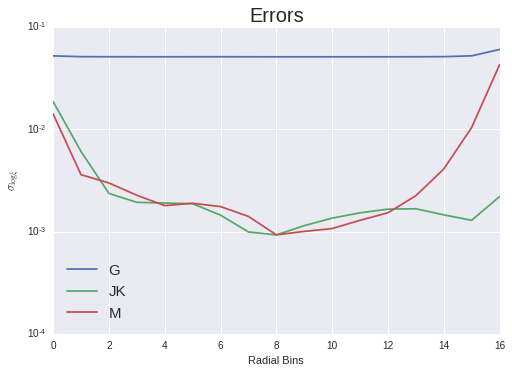

In [201]:
plt.plot(xrange(G.shape[0]), np.sqrt(np.diag(G)), label = 'G')
plt.plot(xrange(G.shape[0]), np.sqrt(np.diag(G_jk)), label = 'JK')
plt.plot(xrange(M.shape[0]), np.sqrt(np.abs(np.diag(M))) , label = 'M')

plt.title('Errors', fontsize = 20)
plt.yscale('log')
plt.xlabel('Radial Bins')
plt.ylabel(r'$\sigma_{\log{\xi}}$')
plt.legend(loc = 'best', fontsize = 15)
plt.show()

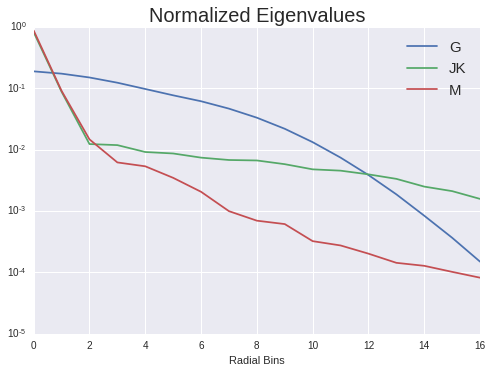

In [204]:
from scipy.linalg import eigh
for mat, label,c in zip((G, G_jk,M), ['G', 'JK','M'], colors):
    eigvals = sorted(eigh(mat,eigvals_only=True), reverse = True)
    norm_eigvals = eigvals/np.sum(eigvals)
    #print norm_eigvals
    plt.plot(norm_eigvals, label = label, color = c)
    
plt.title('Normalized Eigenvalues', fontsize = 20)
plt.yscale('log')
plt.xlabel('Radial Bins')
plt.legend(loc = 'best', fontsize = 15)
plt.show()

In [ ]:
true_mu = np.array([ 2.20174851807 , 2.88325743465 , 2.51060313673 , 2.19896197994 , 1.85712414196 , 
           1.47401750055 , 1.10341573437 , 0.751457707823 , 0.485277384642 , 0.258011202361 , 
           0.021714470088 , -0.197396627251 , -0.449811268077 , -0.723888488999 , -1.02478190596 ,
           -1.36306559547 , -1.87144128453 ])

In [ ]:
plt.errorbar(rpoints, mu,yerr=np.sqrt(np.diag(G)), label = 'G', fmt='o-')
plt.errorbar(rpoints,mu+1, yerr=np.sqrt(np.diag(G_jk)), label = 'JK', fmt='o-')
plt.plot(rpoints, true_mu, label = 'True')
plt.legend(loc='best')
plt.show()